# Part 1: Genres and communities and plotting
---

In [14]:
def calculate_modularity(G, community_partition):
    """
    Calculate modularity for a given partition of the network based on equation 9.12.

    Parameters:
    G (networkx.Graph): The undirected graph for which modularity is calculated.
    community_partition (dict): A dictionary where keys are nodes and values are community labels.

    Returns:
    float: The modularity score.
    """
    m = G.number_of_edges()
    modularity = 0.0

    # Group nodes by community
    communities = {}
    for node, community in community_partition.items():
        if community not in communities:
            communities[community] = set()
        communities[community].add(node)

    # Calculate modularity
    for community_nodes in communities.values():
        # Sum of degrees of nodes in the community
        k_c = sum(G.degree(node) for node in community_nodes)
        
        # Number of edges within the community
        L_c = G.subgraph(community_nodes).number_of_edges()

        # Contribution to modularity for this community
        modularity += (L_c / m) - (k_c / (2 * m)) ** 2

    return modularity

In [12]:
import networkx as nx
import json

# Step 1: Load the graph and make it undirected
G = nx.read_graphml('country_music_graph.graphml')
G = G.to_undirected()

# Step 2: Load genre data and map each artist to their primary genre
with open('genre.txt', 'r') as f:
    genre_data = json.load(f)


# Create a mapping of nodes to their primary genre (first genre listed)
primary_genre = {artist.replace(' ', '_'): genres[0] for artist, genres in genre_data.items() if genres}

# Step 3: Assign genres to nodes and filter out those without genre information
nodes_with_genre = {node: primary_genre[node] for node in G.nodes if node in primary_genre}
G_filtered = G.subgraph(nodes_with_genre.keys()).copy()

# Recalculate node degrees and number of edges for the filtered graph
node_degrees = dict(G_filtered.degree())
m = G_filtered.number_of_edges()


from networkx.algorithms.community.quality import modularity

# Calculate modularity using NetworkX's built-in function
modularity_value = modularity(G_filtered, [{node for node in G_filtered if nodes_with_genre[node] == genre} for genre in set(nodes_with_genre.values())])

print(f"The modularity M of the network partitioned by genres is (using networkx): {modularity_value:.4f}")

# Create a community partition based on genres
community_partition = {node: nodes_with_genre[node] for node in G_filtered.nodes()}

# Calculate modularity using the custom function
modularity_value = calculate_modularity(G_filtered, community_partition)

print(f"The modularity M of the network partitioned by genres is (using eq 9.12): {modularity_value:.4f}")



The modularity M of the network partitioned by genres is (using networkx): 0.0710
The modularity M of the network partitioned by genres is (using eq 9.12): 0.0710


In [16]:
# Adjust genre assignment: Use the first non-country genre if available
adjusted_genre = {}
for artist, genres in genre_data.items():
    artist_name = artist.replace(' ', '_')
    # Assign the first genre that is not "country" if possible
    primary_genre = next((genre for genre in genres if genre != "country"), genres[0])
    adjusted_genre[artist_name] = primary_genre

# Step 3: Assign genres to nodes and filter out those without genre information
nodes_with_genre = {node: adjusted_genre[node] for node in G.nodes if node in adjusted_genre}
G_filtered = G.subgraph(nodes_with_genre.keys()).copy()

# Recalculate node degrees and number of edges for the filtered graph
node_degrees = dict(G_filtered.degree())
m = G_filtered.number_of_edges()

from networkx.algorithms.community.quality import modularity

# Calculate modularity using NetworkX's built-in function with adjusted genres
modularity_value = modularity(G_filtered, [{node for node in G_filtered if nodes_with_genre[node] == genre} for genre in set(nodes_with_genre.values())])

print(f"The modularity M of the network partitioned by adjusted genres is (networkx): {modularity_value:.4f}")

# Create a community partition based on genres
community_partition = {node: nodes_with_genre[node] for node in G_filtered.nodes()}

# Calculate modularity using the custom function
modularity_value = calculate_modularity(G_filtered, community_partition)

print(f"The modularity M of the network partitioned by genres is (eq 9.12): {modularity_value:.4f}")



The modularity M of the network partitioned by adjusted genres is (networkx): 0.0841
The modularity M of the network partitioned by genres is (eq 9.12): 0.0841


In [ ]:
import community as community_louvain

# Step 4: Detect communities using the Louvain algorithm and calculate modularity
partition = community_louvain.best_partition(G_filtered)
modularity_score = community_louvain.modularity(partition, G_filtered)

print(f"The modularity M of the network based on Louvain communities is(networkx): {modularity_score:.4f}")

# Calculate modularity using the custom function
modularity_value = calculate_modularity(G_filtered, partition)

print(f"The modularity M of the network partitioned by genres is(eq 9.12): {modularity_value:.4f}")




The modularity M of the network based on Louvain communities is: 0.3989
The modularity M of the network partitioned by genres is: 0.3989


Louvain algorithm modularity: 0.3817


100%|██████████| 2000/2000 [00:34<00:00, 58.21it/s]


BarnesHut Approximation  took  9.09  seconds
Repulsion forces  took  23.86  seconds
Gravitational forces  took  0.11  seconds
Attraction forces  took  0.22  seconds
AdjustSpeedAndApplyForces step  took  0.52  seconds


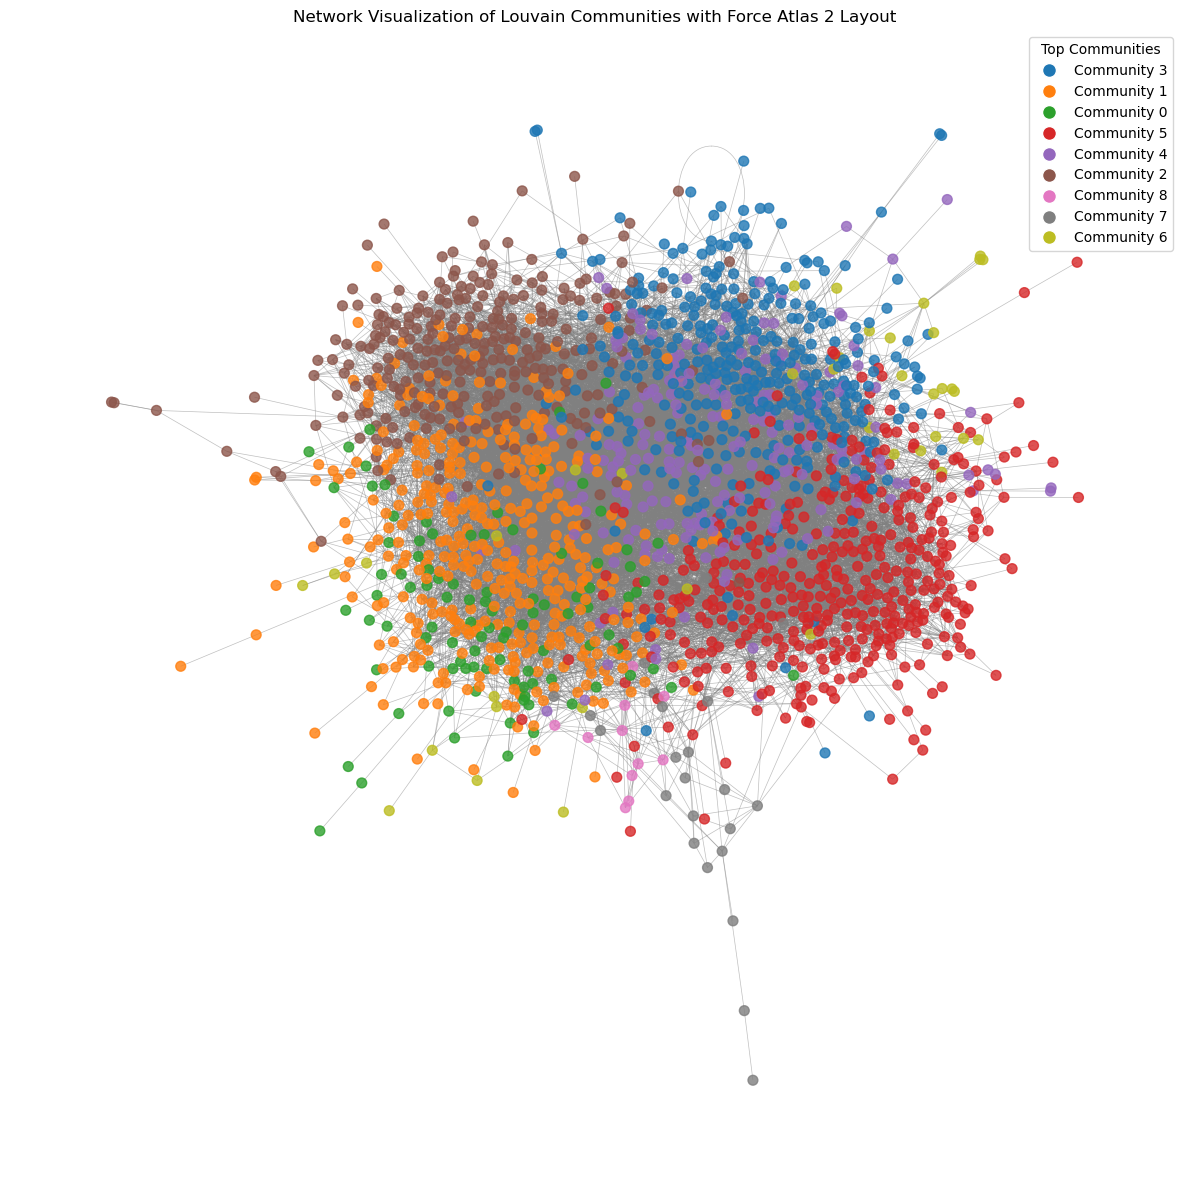

In [15]:
import networkx as nx
import json
import community as community_louvain
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from fa2_modified import ForceAtlas2  # Ensure the ForceAtlas2 package is installed


# Prepare genre mapping
artist_genres = {artist.replace(' ', '_'): genres for artist, genres in genre_data.items()}
nodes_with_genre = set(artist_genres.keys())
G_filtered = G.subgraph(nodes_with_genre).copy()

# Remove isolated nodes
isolated_nodes = list(nx.isolates(G_filtered))
G_filtered.remove_nodes_from(isolated_nodes)

# Step 2: Apply the Louvain algorithm for community detection
partition = community_louvain.best_partition(G_filtered)
modularity = calculate_modularity(G_filtered, partition)
print(f"Louvain algorithm modularity: {modularity:.4f}")

# Step 3: Analyze community structure
community_sizes = Counter(partition.values())
sorted_communities = community_sizes.most_common()

# Step 4: Prepare visualization with colors for top communities
top_communities = [community for community, size in sorted_communities[:10]]
color_map = plt.get_cmap('tab10')  # Up to 10 distinct colors for top communities
node_colors = []

for node in G_filtered.nodes():
    community_id = partition[node]
    node_colors.append(color_map(community_id % 10) if community_id in top_communities else 'lightgray')

# Step 5: Compute Force Atlas 2 layout
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=False,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=2.0,
    gravity=1.0,
    verbose=True
)
positions = forceatlas2.forceatlas2_networkx_layout(G_filtered, iterations=2000)

# Step 6: Draw the network with community colors
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G_filtered, positions, node_size=50, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G_filtered, positions, edge_color='gray', alpha=0.5, width=0.5)
plt.axis("off")

# Create legend for top communities
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=f"Community {community}",
               markerfacecolor=color_map(i % 10), markersize=10) 
    for i, (community, _) in enumerate(sorted_communities[:10])
]
plt.legend(handles=handles, loc="best", title="Top Communities")
plt.title("Network Visualization of Louvain Communities with Force Atlas 2 Layout")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from collections import Counter

# Step 1: Collect all genres for each node
node_genres = {artist.replace(' ', '_'): genres for artist, genres in genre_data.items() if genres}

# Step 2: Filter nodes to include only those with genres, then create subgraph if necessary
nodes_with_genre = {node: node_genres[node] for node in G.nodes if node in node_genres}
G_filtered = G.subgraph(nodes_with_genre.keys()).copy()

# Step 3: Detect communities if not already provided (use existing `partition` from Louvain in this example)
partition = community_louvain.best_partition(G_filtered)  # If you need to re-run the Louvain algorithm

# Step 4: Identify top 7 most common genres and top 7 most common communities
all_genres = [genre for genres in node_genres.values() for genre in genres]
top_genres = [genre for genre, _ in Counter(all_genres).most_common(7)]
top_communities = [community for community, _ in Counter(partition.values()).most_common(7)]

# Step 5: Initialize a confusion matrix as a DataFrame with genre names and community IDs
confusion_matrix = pd.DataFrame(0, index=top_genres, columns=top_communities)

# Step 6: Populate the confusion matrix
for node, genres in nodes_with_genre.items():
    if node in partition:  # Ensure node is part of the community partition
        community_id = partition[node]
        if community_id in top_communities:  # Only include top communities
            for genre in genres:
                if genre in top_genres:  # Only include top genres
                    confusion_matrix.loc[genre, community_id] += 1

# Print
print("Top 7 genres:", top_genres)
print("Top 7 communities (sorted by frequency):", top_communities)
print("\nCommunity vs Genre Confusion Matrix:")
print(confusion_matrix)

Top 7 genres: ['country', 'folk', 'country rock', 'pop', 'americana', 'bluegrass', 'rock']
Top 7 communities (sorted by frequency): [10, 1, 6, 0, 5, 7, 9]

Community vs Genre Confusion Matrix:
               10   1    6    0   5   7   9 
country       453  328  386  230  20  27  20
folk           11  115   31    3   6   1   0
country rock   59   55   22   20   9   5   0
pop            55   37   50   12   0   1   1
americana      16  105   20    3  11   1   0
bluegrass      11   88    9   14   5   0   0
rock           25   55   20    9   2   3   0


Explanation
Genre and Community Identification:
The code identifies the top 7 genres and communities by frequency.
Matrix Setup:
A matrix D is created with dimensions 7x7, where each cell counts nodes that share a given genre-community pairing.
Interpretation:
The resulting matrix (confusion matrix) displays genre-community alignment, showing how well the detected communities align with genres.

---
# Part 2: TF-IDF to understand genres and communities
---

---
# Part 3: Sentiment of the artists and communities
---

In [12]:
import os
import re
import pandas as pd

# Load the LabMT word list into a dictionary for use in sentiment analysis
def load_labmt_wordlist(file_path):
    """
    Load the LabMT word list from a text file into a dictionary where words are keys
    and happiness scores are values.
    """
    column_names = ['word', 'happiness_rank', 'happiness_average', 'happiness_standard_deviation',
                    'twitter_rank', 'google_rank', 'nyt_rank', 'lyrics_rank']
    
    # Load the LabMT word list with the specified columns, skipping initial non-data lines
    labmt_data = pd.read_csv(file_path, sep='\t', skiprows=2, names=column_names)
    # Convert 'happiness_average' to numeric and drop non-numeric entries
    labmt_data['happiness_average'] = pd.to_numeric(labmt_data['happiness_average'], errors='coerce')
    labmt_data = labmt_data.dropna(subset=['happiness_average'])
    
    # Create a dictionary with words as keys and happiness scores as values
    happiness_dict = dict(zip(labmt_data['word'], labmt_data['happiness_average']))
    return happiness_dict

# Function to calculate sentiment score using LabMT word list
def calculate_sentiment(tokens, happiness_dict, neutral_threshold=5.0):
    """
    Calculate the sentiment score of a list of tokens using the LabMT word list.
    """
    scores = []
    for token in tokens:
        score = happiness_dict.get(token)
        # Only include words with scores that differ significantly from the neutral threshold
        if score and abs(score - neutral_threshold) > 1.0:
            scores.append(score)
    
    # Return the average sentiment score, or None if no valid words were found
    return sum(scores) / len(scores) if scores else None

# Function to tokenize the text by converting to lowercase and splitting by whitespace and punctuation
def tokenize_text(text):
    """
    Tokenize the input text into lowercase words, ignoring punctuation.
    """
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens

# Function to calculate sentiment for each artist's page
def calculate_artist_sentiments(directory_path, happiness_dict):
    """
    Calculate the sentiment score for each text file in a directory and return a dictionary.
    """
    artist_sentiments = {}
    
    # Iterate through each file in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".txt"):  # Only process .txt files
            file_path = os.path.join(directory_path, filename)
            
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
                
            # Tokenize the text
            tokens = tokenize_text(text)
            
            # Calculate sentiment score for the tokenized text
            sentiment_score = calculate_sentiment(tokens, happiness_dict)
            
            # Store sentiment score with filename (artist) as the key
            artist_sentiments[filename] = sentiment_score
    
    return artist_sentiments

# Specify the path to the LabMT word list file
file_path = 'labMIT-1.0.txt'

# Load the LabMT word list
happiness_dict = load_labmt_wordlist(file_path)

# Specify the directory path for country music performers
directory_path = 'country_music_performers'

# Calculate sentiment scores for each artist's page
artist_sentiments = calculate_artist_sentiments(directory_path, happiness_dict)

# Display the sentiment scores
artist_sentiments


{'Harry_McClintock.txt': 6.406433734939756,
 'Haley_&_Michaels.txt': 6.630117647058822,
 'Dickey_Betts.txt': 6.254839924670439,
 'Two_Tons_of_Steel.txt': 6.522873563218388,
 'Bacon_Brothers.txt': 6.98,
 'Cledus_T._Judd.txt': 6.329669966996701,
 'Charlie_Major.txt': 6.642797927461133,
 'Caryl_Mack_Parker.txt': 6.513076923076923,
 'Tenille_Arts.txt': 6.548525179856136,
 'Tyler_Hubbard.txt': 6.4588766519823695,
 'Roy_Rogers.txt': 6.433022813688221,
 'Steven_Lee_Olsen.txt': 6.601247524752475,
 'O._B._McClinton.txt': 6.268154506437763,
 'JT_Hodges.txt': 6.408661800486609,
 'Hank_Flamingo.txt': 6.366079545454543,
 'My_Darling_Clementine_(band).txt': 6.6899999999999995,
 'Shawn_Camp_(singer).txt': 6.370178041543019,
 'The_Dirt_Drifters.txt': 6.113571428571428,
 'Valerie_June.txt': 6.458049261083771,
 'Roxie_Dean.txt': 6.5459605911329986,
 'Warren_Zeiders.txt': 6.212918088737229,
 'Will_Hoge.txt': 6.290626151012896,
 'Osborne_Brothers.txt': 6.315682451253478,
 'Nick_Hoffman.txt': 6.64112781954

### Description of Sentiment Analysis Findings for Country Music Artist Profiles

Using the LabMT word list, we calculated sentiment scores for a collection of country music artist profiles. The function will:

1. Load the LabMT word list, mapping each word to its happiness score.
2. Process each token, checking if it exists in the LabMT list.
3. Sum the happiness scores for tokens that are present in the list and calculate an average score.


The sentiment scores of most wikis is around 6.1 to 6.9, with most profiles clustering around a slightly positive score near 6.4. 

This result aligns with typical patterns in general language sentiment, where LabMT scores often fall between 5 and 7 due to a natural linguistic tendency toward mild positivity. 

In this context, words reflecting everyday positivity, such as “good,” “music,” and “success,” tend to push sentiment scores just above 6, while strongly negative words are relatively rare. 

This suggests that the profiles generally employ favorable language, focusing on career highlights, achievements, and the appealing qualities of each artist. The slight variations within the 6.1–6.9 range indicate that while some profiles are more neutral, others emphasize more enthusiastic or celebratory descriptions. 



In [13]:
import numpy as np

# Calculate basic statistics for the sentiment scores
def calculate_statistics(artist_sentiments):
    """
    Calculate average, median, variance, 25th percentile, and 75th percentile of sentiment scores.
    """
    # Extract sentiment scores as a list, excluding None values
    sentiment_scores = [score for score in artist_sentiments.values() if score is not None]
    
    # Check if we have valid scores to calculate statistics
    if len(sentiment_scores) == 0:
        return {
            "average": None,
            "median": None,
            "variance": None,
            "25th_percentile": None,
            "75th_percentile": None
        }
    
    # Calculate statistics
    average_sentiment = np.mean(sentiment_scores)
    median_sentiment = np.median(sentiment_scores)
    variance_sentiment = np.var(sentiment_scores)
    percentile_25 = np.percentile(sentiment_scores, 25)
    percentile_75 = np.percentile(sentiment_scores, 75)
    
    # Return the statistics as a dictionary
    return {
        "average": average_sentiment,
        "median": median_sentiment,
        "variance": variance_sentiment,
        "25th_percentile": percentile_25,
        "75th_percentile": percentile_75
    }

# Calculate statistics for the sentiment scores
statistics = calculate_statistics(artist_sentiments)

# Display the results
statistics


{'average': 6.3995517311408285,
 'median': 6.413586206896536,
 'variance': 0.04319745655306958,
 '25th_percentile': 6.321995498874737,
 '75th_percentile': 6.497872340425527}

### Description of Average Sentiment across All The Pages

The average sentiment across all country music artist pages is approximately 6.4, indicating a generally positive tone in the content. 

The median is close to the mean, suggesting a symmetric distribution of sentiment scores, with most profiles slightly above neutral. The 25th and 75th percentiles (6.32 and 6.50, respectively) reveal a narrow interquartile range, meaning there is little variation between the sentiment of different profiles. 

This small variance (0.04) confirms that the profiles consistently exhibit a mild positivity, reflective of the favorable language often used in artist biographies.

This makes sense because when you read wikis yourself, they are often written in a similair tone.

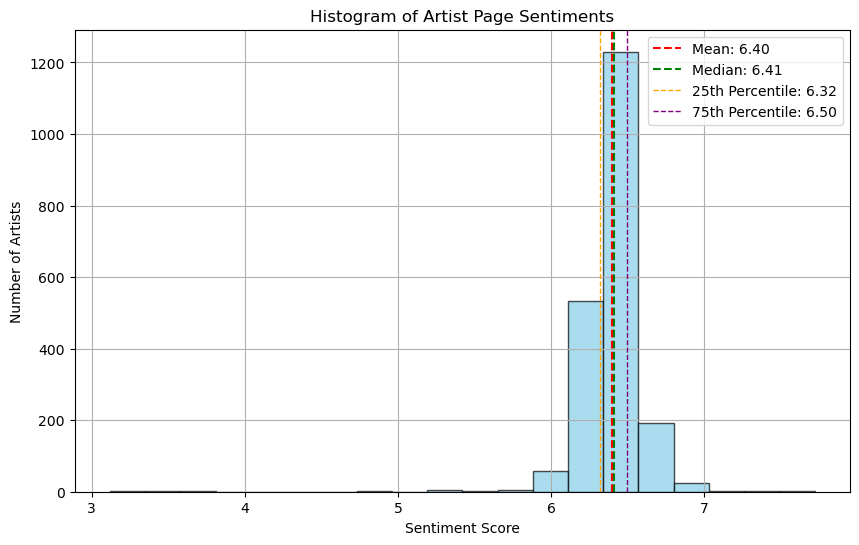

In [27]:
import os
import re
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Directory containing individual performer files
directory_path = 'country_music_performers'

# Load LabMT word list for sentiment analysis
def load_labmt_wordlist(file_path):
    column_names = ['word', 'happiness_rank', 'happiness_average', 'happiness_standard_deviation',
                    'twitter_rank', 'google_rank', 'nyt_rank', 'lyrics_rank']
    labmt_data = pd.read_csv(file_path, sep='\t', skiprows=2, names=column_names)
    labmt_data['happiness_average'] = pd.to_numeric(labmt_data['happiness_average'], errors='coerce')
    labmt_data = labmt_data.dropna(subset=['happiness_average'])
    happiness_dict = dict(zip(labmt_data['word'], labmt_data['happiness_average']))
    return happiness_dict

# Function to calculate sentiment score using LabMT word list
def calculate_sentiment(tokens, happiness_dict, neutral_threshold=5.0):
    scores = []
    for token in tokens:
        score = happiness_dict.get(token)
        if score and abs(score - neutral_threshold) > 1.0:
            scores.append(score)
    return sum(scores) / len(scores) if scores else None

# Function to tokenize text content
def tokenize_text(text):
    return re.findall(r'\b\w+\b', text.lower())

# Initialize the graph and load the LabMT word list
G = nx.DiGraph()
happiness_dict = load_labmt_wordlist("labMIT-1.0.txt")

# Load text content, calculate word count and sentiment, and add nodes and edges
for performer_file in os.listdir(directory_path):
    if performer_file.endswith(".txt"):
        performer_name = os.path.splitext(performer_file)[0]
        file_path = os.path.join(directory_path, performer_file)
        
        # Read page content
        with open(file_path, 'r', encoding='utf-8') as file:
            wikitext = file.read()
        
        # Tokenize text and calculate sentiment score
        tokens = tokenize_text(wikitext)
        sentiment_score = calculate_sentiment(tokens, happiness_dict)
        
        # Add node with sentiment attribute
        G.add_node(performer_name, content_length=len(tokens), sentiment=sentiment_score)

        # Extract and add edges based on links in text
        links = re.findall(r'\[\[(.*?)\]\]', wikitext)
        for link in links:
            linked_performer = link.split('|')[0]
            linked_performer = linked_performer.replace(" ", "_").replace("-", "_")
            if linked_performer in G.nodes:
                G.add_edge(performer_name, linked_performer)

# Extract sentiment scores for histogram, excluding None values
sentiment_scores = [G.nodes[performer].get('sentiment') for performer in G.nodes if G.nodes[performer].get('sentiment') is not None]

# Calculate statistics
mean_sentiment = np.mean(sentiment_scores)
median_sentiment = np.median(sentiment_scores)
percentile_25 = np.percentile(sentiment_scores, 25)
percentile_75 = np.percentile(sentiment_scores, 75)

# Plot histogram of sentiment scores with additional statistical lines
plt.figure(figsize=(10, 6))
plt.hist(sentiment_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Add mean and median lines
plt.axvline(mean_sentiment, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_sentiment:.2f}')
plt.axvline(median_sentiment, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median_sentiment:.2f}')

# Add percentile lines
plt.axvline(percentile_25, color='orange', linestyle='dashed', linewidth=1, label=f'25th Percentile: {percentile_25:.2f}')
plt.axvline(percentile_75, color='purple', linestyle='dashed', linewidth=1, label=f'75th Percentile: {percentile_75:.2f}')

# Add title, labels, legend, and grid
plt.title('Histogram of Artist Page Sentiments')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Artists')
plt.legend()
plt.grid(True)
plt.show()


### Description of Histogram of Sentiment Score

We see that most wikis are in the 6-7 range, but we a few outliers.

In [22]:
# Filter nodes to include only those with a sentiment score
performer_sentiments = {node: G.nodes[node]['sentiment'] for node in G.nodes if G.nodes[node].get('sentiment') is not None}

# Sort performers by sentiment score in ascending order (saddest first, happiest last)
sorted_performers = sorted(performer_sentiments.items(), key=lambda x: x[1])

# Get the 10 saddest performers
saddest_performers = sorted_performers[:10]

# Get the 10 happiest performers
happiest_performers = sorted_performers[-10:]

# Display the results
print("10 Saddest Performers:")
for performer, sentiment in saddest_performers:
    print(f"{performer}: {sentiment}")

print("\n10 Happiest Performers:")
for performer, sentiment in happiest_performers:
    print(f"{performer}: {sentiment}")


10 Saddest Performers:
Cole_Deggs_&_The_Lonesome: 3.12
Mats_Radberg: 3.54
Brian_Kelley_(musician): 3.78
Jimmie_Rodgers_(country_singer): 3.78
Kerry_Harvick: 4.79
Riley_Green_(singer): 5.28
Bill_'Cowboy_Rambler'_Boyd: 5.3100000000000005
Those_Poor_Bastards: 5.3107801418439715
Love_and_Theft_(band): 5.359999999999999
Bobby_Cash_(singer): 5.6

10 Happiest Performers:
Donny_Parenteau: 6.836616438356158
Soggy_Bottom_Boys: 6.91
Girls_Next_Door_(band): 6.94
The_JaneDear_Girls: 6.94
Brad_Johner: 6.940273224043699
Bacon_Brothers: 6.98
Carl_Smith_(country_musician): 6.98
Amazing_Rhythm_Aces: 7.155
Dick_Feller: 7.32
The_Carter_Family: 7.72


### Description of Top 10 Happiest and Saddest Performers

Here we get a look into the outliers, and as we can see here it's only very few wikis with low sentiment score and the highest sentiment score we get is 7.72. This isn't that much compared to the almost 2000 wikis centered around the 6-7 range, so we have a very center heavy distribution.

In [26]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import numpy as np

# Step 1: Detect communities in the graph using a community detection algorithm (e.g., Greedy modularity)
communities = list(greedy_modularity_communities(G))

# Step 2: Calculate the average sentiment for each community
community_sentiments = []
for i, community in enumerate(communities):
    # Collect sentiment scores for nodes in the community
    community_sentiment_scores = [G.nodes[node].get('sentiment') for node in community if G.nodes[node].get('sentiment') is not None]
    
    # Calculate the average sentiment for the community if scores are available
    if community_sentiment_scores:
        avg_sentiment = np.mean(community_sentiment_scores)
        community_sentiments.append((i, avg_sentiment, len(community)))
    else:
        community_sentiments.append((i, None, len(community)))  # None if no sentiment data is available

# Sort communities by size (largest to smallest) and display their average sentiment
sorted_community_sentiments = sorted(community_sentiments, key=lambda x: x[2], reverse=True)

# Display results for the largest communities
print("Sentiment Analysis of the Largest Communities:")
for community_id, avg_sentiment, size in sorted_community_sentiments[:100]:  # Display top 5 largest communities
    print(f"Community {community_id}: Size = {size}, Average Sentiment = {avg_sentiment}")


Sentiment Analysis of the Largest Communities:
Community 0: Size = 632, Average Sentiment = 6.404661966507965
Community 1: Size = 605, Average Sentiment = 6.367945695843728
Community 2: Size = 192, Average Sentiment = 6.396235182878346
Community 3: Size = 110, Average Sentiment = 6.440113399935499
Community 4: Size = 66, Average Sentiment = 6.400405832531619
Community 5: Size = 36, Average Sentiment = 6.524186133802187
Community 6: Size = 34, Average Sentiment = 6.412985691104544
Community 7: Size = 30, Average Sentiment = 6.379376138756383
Community 8: Size = 24, Average Sentiment = 6.43435280953847
Community 9: Size = 9, Average Sentiment = 6.421417622759844
Community 10: Size = 6, Average Sentiment = 6.397469980144629
Community 11: Size = 6, Average Sentiment = 6.420968592160377
Community 12: Size = 6, Average Sentiment = 6.339023049586018
Community 13: Size = 5, Average Sentiment = 6.263189307970239
Community 14: Size = 5, Average Sentiment = 6.402016084640453
Community 15: Size = 

### Description of Sentiment Analysis of the Largest Communities

The sentiment analysis shows a consistent, mildly positive tone across the largest communities, with average sentiment scores clustering around 6.4. Larger communities reflect mainstream themes in country music, maintaining a moderate positivity, while smaller communities show slight variations, possibly due to unique or niche topics. 

### Do the findings using TF-IDF during Lecture 7 help you understand your results?

...
